# Dataset: BBC_News

## 1. Import data and libraries

In [ ]:
import csv
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

import nltk

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/protonx-cloud-storage/bbc-text.csv \
  -O /tmp/bbc-text.csv

--2020-10-28 21:43:42--  https://storage.googleapis.com/protonx-cloud-storage/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2020-10-28 21:43:42 (191 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



## Set the constants

In [ ]:
vocab_size = 1000
embedding_dimension = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

## Import the stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords as stop_words

In [ ]:
sentences = []
labels = []

stopwords = set(stop_words.words('english')) 
print(len(stopwords))

179


## Read the data

In [ ]:
with open('/tmp/bbc-text.csv', 'r') as csvfile: 
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader: 
    labels.append(row[0])
    sentence = row[1]

    for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    
    sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend  programmes content delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us tivo uk sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take europe lack high-definition programming. people forward wind adverts  also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite 

## 2. Preprocess the data

In [ ]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


### Connect with tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, 
                      oov_token=oov_tok)

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, 
                             padding=padding_type,
                             truncating=trunc_type, 
                             maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, 
                             padding=padding_type,
                             truncating=trunc_type, 
                             maxlen=max_length)


print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(validation_sequences))
print(validation_padded.shape)

425
120
192
120
445
(445, 120)


In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
label_tokenizer.word_index

{'business': 2, 'entertainment': 5, 'politics': 3, 'sport': 1, 'tech': 4}

## 3. Create the model

In [ ]:
model = Sequential([
                      Embedding(vocab_size, 
                                embedding_dimension, 
                                input_length=max_length), 
                      GlobalAveragePooling1D(), 
                      Dense(24, activation='relu'), 
                      Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
num_epochs = 30
history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=1)

Epoch 1/30
56/56 [==============================] - 0s 5ms/step - loss: 1.7640 - acc: 0.2225 - val_loss: 1.7247 - val_acc: 0.2270
Epoch 2/30
56/56 [==============================] - 0s 4ms/step - loss: 1.6752 - acc: 0.2303 - val_loss: 1.6206 - val_acc: 0.2360
Epoch 3/30
56/56 [==============================] - 0s 4ms/step - loss: 1.5491 - acc: 0.3809 - val_loss: 1.4760 - val_acc: 0.4517
Epoch 4/30
56/56 [==============================] - 0s 4ms/step - loss: 1.3738 - acc: 0.5034 - val_loss: 1.2877 - val_acc: 0.5461
Epoch 5/30
56/56 [==============================] - 0s 4ms/step - loss: 1.1631 - acc: 0.5843 - val_loss: 1.0811 - val_acc: 0.6337
Epoch 6/30
56/56 [==============================] - 0s 4ms/step - loss: 0.9526 - acc: 0.6551 - val_loss: 0.8946 - val_acc: 0.7753
Epoch 7/30
56/56 [==============================] - 0s 4ms/step - loss: 0.7754 - acc: 0.7798 - val_loss: 0.7490 - val_acc: 0.8157
Epoch 8/30
56/56 [==============================] - 0s 4ms/step - loss: 0.6365 - acc: 0.86

## 4. Evaluate the model

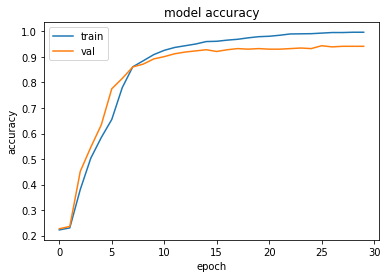

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

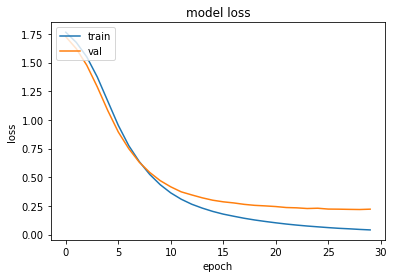

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 5. Do the prediction

In [ ]:
test_sentence = ('hobbit picture four years away lord of the rings')
test_sentence_sequence = tokenizer.texts_to_sequences(test_sentence)

test_sentence_padded = pad_sequences(test_sentence_sequence, 
                                     padding=padding_type, 
                                     truncating=trunc_type, 
                                     maxlen=max_length)
                                                  
result = model.predict(test_sentence_padded)[0]
print(result, labels[np.argmax(result)])

[1.2012956e-07 9.8422921e-01 2.7417505e-04 1.5479623e-02 2.6005111e-09
 1.6851622e-05] business
